Name:
Project 5: Planing Advertising Campaign

Introduction:
Identify patterns to be able to plan a successful advertising campaign based on recent logical gamming data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from scipy.stats import ttest_ind




In [2]:
games = pd.read_csv('games.csv')

In [3]:
games.columns = games.columns.str.lower()

Made column names lowercase

In [4]:
games.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Below I changed year_of_release from float to int64 because we are not working with partial years. I also changed user_score from object to int64 because game scores are measured with decimals.

In [5]:
# Change 'year_of_release' to int64
games['year_of_release'] = pd.to_numeric(games['year_of_release'], errors='coerce').astype('Int64')  

# Change 'user_score' to float64
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce').astype('float64')

In [6]:
games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


In [7]:
user_score_median = games['user_score'].median()
user_score_mean = games['user_score'].mean()

print(f'Median User Score: {user_score_median}')
print(f'Mean User Score: {user_score_mean}')

Median User Score: 7.5
Mean User Score: 7.125046113306982


In [8]:
critic_score_median = games['critic_score'].median()
print(f'Median Critic Score: {critic_score_median}')

critic_score_mean = games['critic_score'].mean()
print(f'Mean Critic Score: {critic_score_mean}')

Median Critic Score: 71.0
Mean Critic Score: 68.96767850559173


In [9]:
games = games.assign(
    critic_score=games['critic_score'].fillna(critic_score_mean),
    user_score=games['user_score'].fillna(user_score_mean)
)

In [10]:
games.columns[games.isnull().any()]

Index(['name', 'year_of_release', 'genre', 'rating'], dtype='object')

Checking to see what rows can be dropped if any. 

In [11]:
columns_to_check = ['name', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']

missing_percentages = games[columns_to_check].isnull().mean() * 100

print(missing_percentages)

name                0.011965
year_of_release     1.609333
genre               0.011965
critic_score        0.000000
user_score          0.000000
rating             40.478612
dtype: float64


In [12]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)



In [13]:
columns_to_drop_na = ['name', 'year_of_release', 'genre']
games.dropna(subset=columns_to_drop_na, inplace=True)

Dopped missing rows in 'name', 'year_of_release', 'genre' because the percentage of missing values was so low. Filled 'critic_score' and 'user_score' missing values with the mean.

I think there are missing values in Critic Score, User Score and Rating because not every game gets reviewed, and ratings and scores may not have been a process when older games were made.

I filled TBD's with the mean because they have not been rated yet.


In [14]:
print("\nmissing values after dropping:")
print(games.isnull().sum())


missing values after dropping:
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6676
dtype: int64


In [15]:
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

games.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.000000,8.000000,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,68.967679,7.125046,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.000000,8.300000,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.000000,8.000000,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,68.967679,7.125046,NaN,31.38


Year_of_Release

In [16]:
games_per_year = games['year_of_release'].value_counts().sort_index()
print(games_per_year)

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: count, dtype: Int64


The graph shows that in early gaming years there were not a lot of games released but as time went on more games were released with a peak in 2008 and 2009. Then a rapid decline happened and then leveled off from 2012 to 2016.

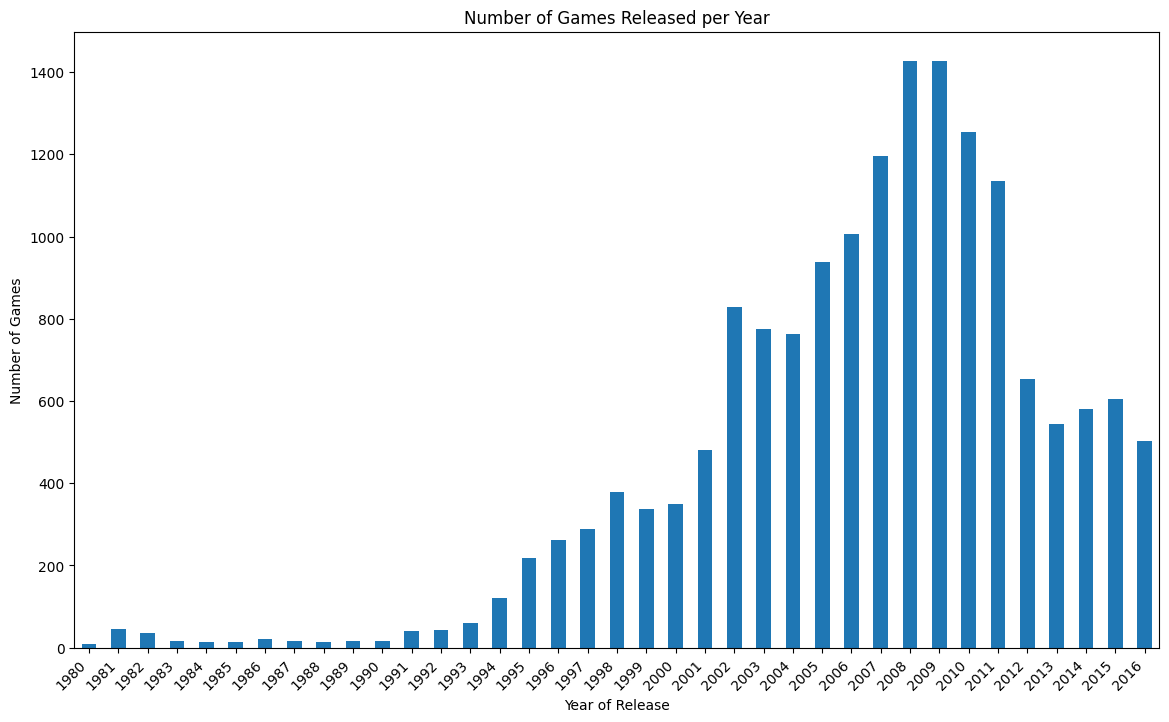

In [17]:
games_per_year.plot(kind='bar', figsize=(14, 8)) 
plt.title('Number of Games Released per Year')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')

plt.show()

Platform 

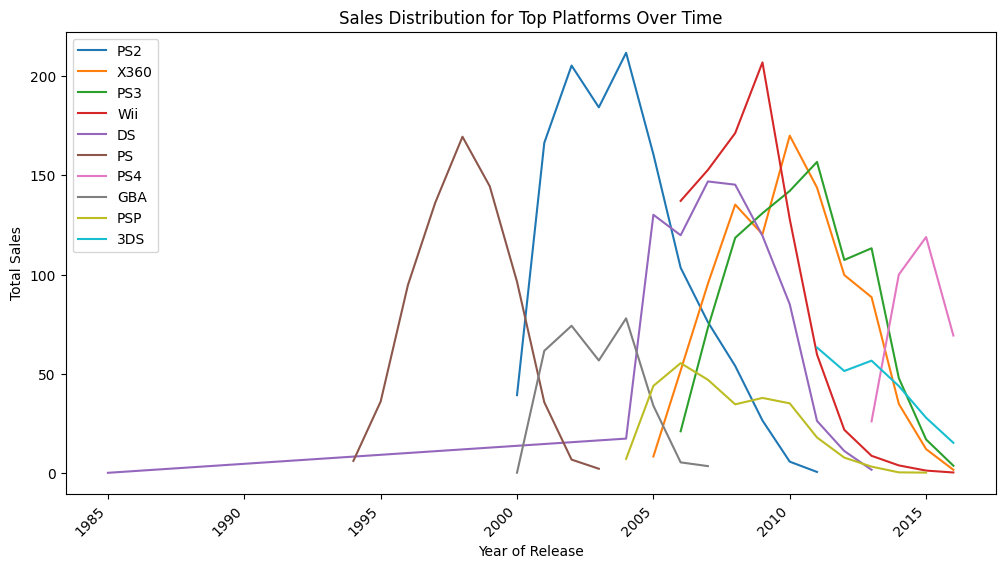

Platforms with low sales in recent years: Index(['3DO', 'GG', 'PCFX'], dtype='object', name='platform')


In [18]:
#Calculate total sales per platform
platform_sales = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)


#Choose top platforms
top_platforms = platform_sales.head(10).index


#Build distributions for top platforms over time
plt.figure(figsize=(12, 6))
for platform in top_platforms:
    platform_data = games[games['platform'] == platform].groupby('year_of_release')['total_sales'].sum()
    plt.plot(platform_data.index, platform_data.values, label=platform)

plt.title('Sales Distribution for Top Platforms Over Time')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()



sales_threshold = 0.1 
recent_years = games['year_of_release'].max() - 25  
recent_platform_sales = games[games['year_of_release'] >= recent_years].groupby('platform')['total_sales'].sum().fillna(0)
platforms_with_low_sales = recent_platform_sales[recent_platform_sales <= sales_threshold].index
platforms_with_low_sales_overall = platform_sales[platform_sales.index.isin(platforms_with_low_sales)].index
print("Platforms with low sales in recent years:", platforms_with_low_sales_overall)

It looks like the lifespan of a platform is just under 10 years with a manufacturer releasing a new one almost every year.

Looking at total sales 

In [19]:
# Filter the data for the years 2012 to 2016
filtered_data = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Select only numerical columns
numerical_columns = filtered_data.select_dtypes(include=[np.number]).columns

# Drop rows with missing values in numerical columns
filtered_data = filtered_data.dropna(subset=numerical_columns)

# Define the features (X) and the target (y)
X = filtered_data[numerical_columns].drop(columns=['total_sales'])
y = filtered_data['total_sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Ridge Regression model
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Display the first few rows of filtered_data and the shapes of X_train and X_test
print(filtered_data.head())
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

Mean Squared Error: 1.3236943254057918e-05
R^2 Score: 0.9999794536989471
                          name platform  year_of_release         genre  \
16          Grand Theft Auto V      PS3             2013        Action   
23          Grand Theft Auto V     X360             2013        Action   
31   Call of Duty: Black Ops 3      PS4             2015       Shooter   
33         Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
34  Call of Duty: Black Ops II      PS3             2012       Shooter   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
16      7.02      9.09      0.98         3.96     97.000000    8.200000   
23      9.66      5.14      0.06         1.41     97.000000    8.100000   
31      6.03      5.86      0.36         2.38     68.967679    7.125046   
33      5.28      4.19      4.35         0.78     68.967679    7.125046   
34      4.99      5.73      0.65         2.42     83.000000    5.300000   

   rating  total_sales  
16    

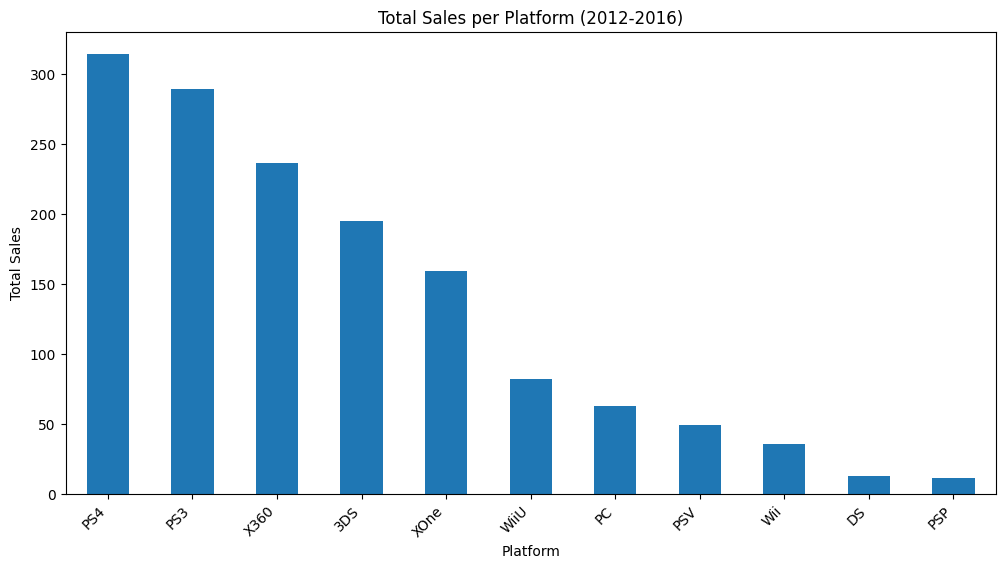

In [20]:
# Filter the data for the years 2012 to 2016
filtered_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Calculate total sales per platform for the filtered data
filtered_platform_sales = filtered_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Plot total sales per platform
plt.figure(figsize=(12, 6))
filtered_platform_sales.plot(kind='bar')
plt.title('Total Sales per Platform (2012-2016)')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

Play station is leading in sales but X360 and 3DS are not far behind. PS4, X360 and 3DS will continue to grow while the others fade. I think the three platforms to watch for the future are PS4, X360 and 3DS.

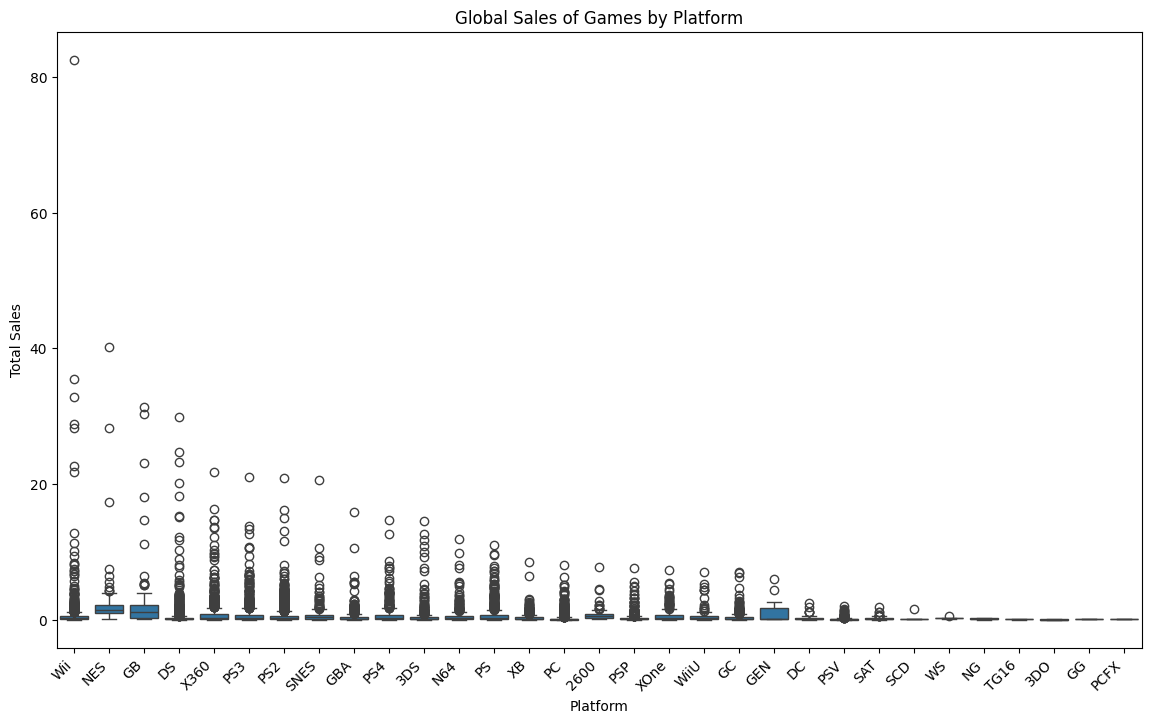

In [21]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='platform', y='total_sales', data=games)
plt.title('Global Sales of Games by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

The Wii leads by a big margin in total game sales. The next three are similar and as you go down the list the number of sales diminishes.

Critic_Score, User_Score

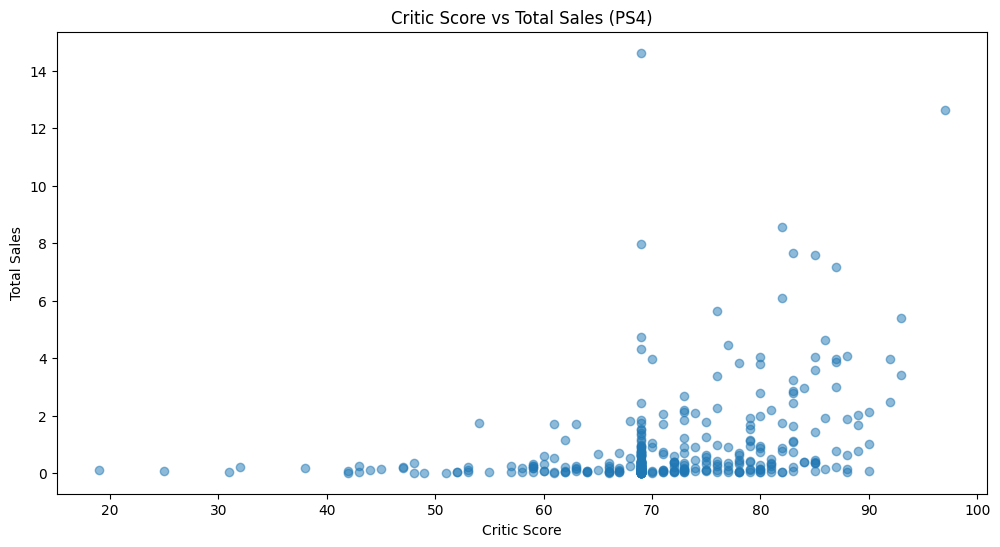

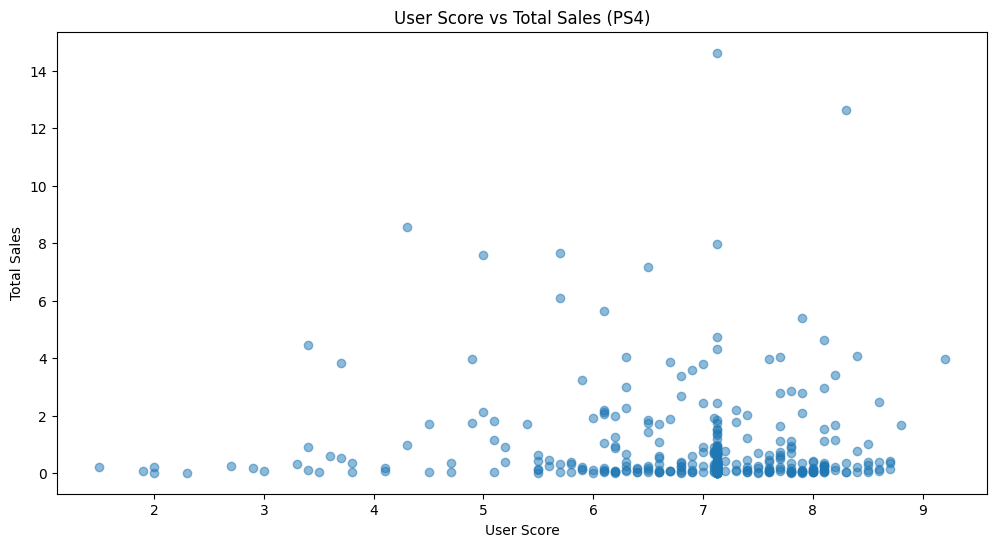

Correlation between Critic Score and Total Sales (PS4): 0.34900958029245677
Correlation between User Score and Total Sales (PS4): -0.0453908610033241


In [22]:
# Filter the data for the PS4 platform
ps4_games = games[games['platform'] == 'PS4']

# Scatter plot for Critic Score vs Total Sales
plt.figure(figsize=(12, 6))
plt.scatter(ps4_games['critic_score'], ps4_games['total_sales'], alpha=0.5)
plt.title('Critic Score vs Total Sales (PS4)')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales')
plt.show()

# Scatter plot for User Score vs Total Sales
plt.figure(figsize=(12, 6))
plt.scatter(ps4_games['user_score'], ps4_games['total_sales'], alpha=0.5)
plt.title('User Score vs Total Sales (PS4)')
plt.xlabel('User Score')
plt.ylabel('Total Sales')
plt.show()

# Calculate the correlation between Critic Score and Total Sales
critic_corr = ps4_games['critic_score'].corr(ps4_games['total_sales'])
print(f'Correlation between Critic Score and Total Sales (PS4): {critic_corr}')

# Calculate the correlation between User Score and Total Sales
user_corr = ps4_games['user_score'].corr(ps4_games['total_sales'])
print(f'Correlation between User Score and Total Sales (PS4): {user_corr}')

It seems that critic score does affect games purchased. The better the score the more games purchased. This is not absolute and there may be other factors not identified by this plot.

User scores do not seem to have a big impact on sales. This potentially means users do not look at other users’ opinions on whether they will purchase a game.


In [23]:
# Filter the data for the PS4, X360, and 3DS platforms
ps4_games = games[games['platform'] == 'PS4']
x360_games = games[games['platform'] == 'X360']
ds3_games = games[games['platform'] == '3DS']

# Find common games between PS4 and X360
common_games_ps4_x360 = pd.merge(ps4_games, x360_games, on='name', suffixes=('_ps4', '_x360'))

# Find common games between the result and 3DS
common_games_all = pd.merge(common_games_ps4_x360, ds3_games, on='name')

# Compare sales
common_games_comparison = common_games_all[['name', 'total_sales_ps4', 'total_sales_x360', 'total_sales']]
common_games_comparison.columns = ['name', 'total_sales_ps4', 'total_sales_x360', 'total_sales_3ds']
print(common_games_comparison)

                                          name  total_sales_ps4  \
0                                      FIFA 15             6.08   
1                                      FIFA 14             3.01   
2                     LEGO Marvel Super Heroes             1.62   
3                 Lego Batman 3: Beyond Gotham             0.92   
4                          LEGO Jurassic World             0.90   
5                       LEGO Marvel's Avengers             0.73   
6            Lego Star Wars: The Force Awakens             0.71   
7                     The LEGO Movie Videogame             0.67   
8                              LEGO The Hobbit             0.60   
9              The Amazing Spider-Man 2 (2014)             0.56   
10                       Skylanders: Trap Team             0.44   
11                       Skylanders SWAP Force             0.38   
12                   Skylanders: SuperChargers             0.30   
13                       Angry Birds Star Wars             0.2

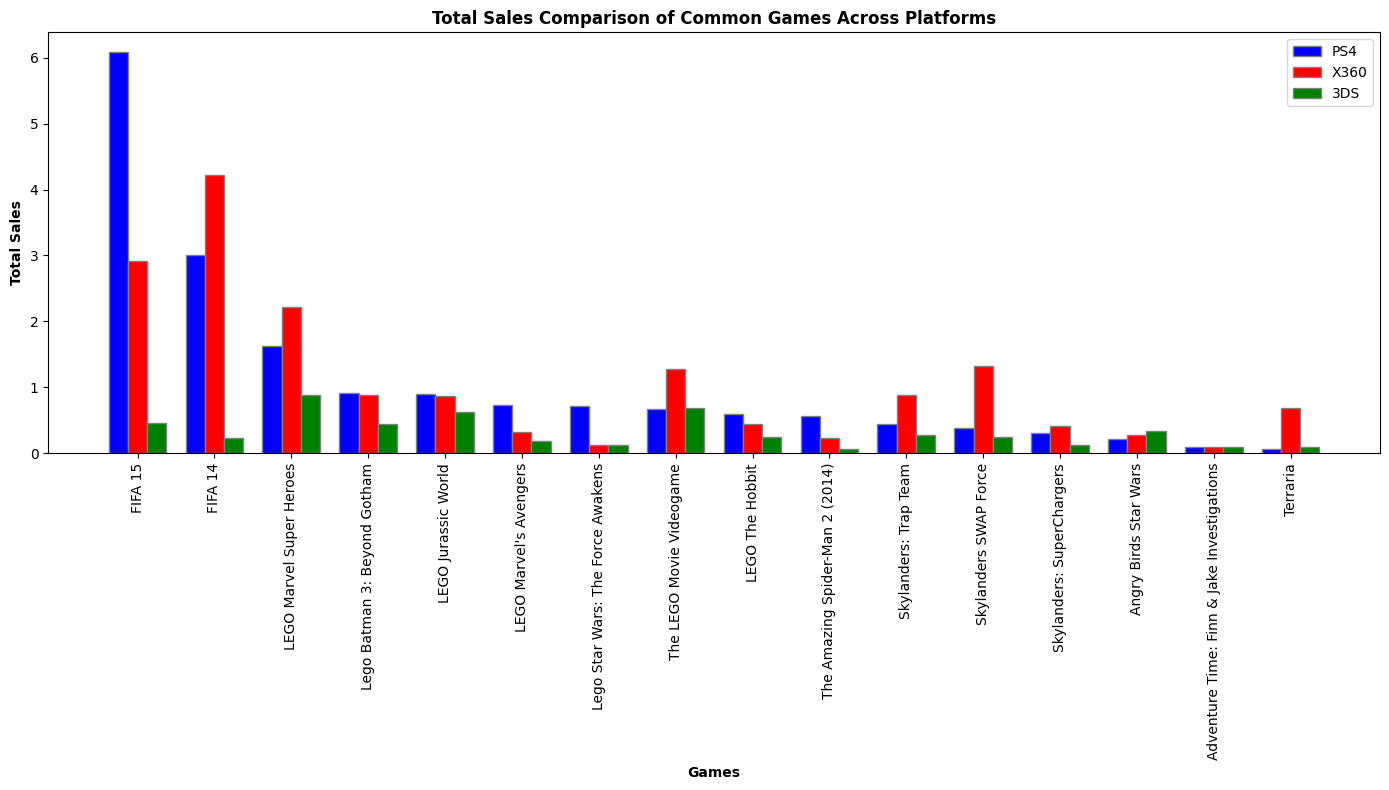

In [24]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Set the bar width
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(common_games_comparison))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, common_games_comparison['total_sales_ps4'], color='b', width=bar_width, edgecolor='grey', label='PS4')
plt.bar(r2, common_games_comparison['total_sales_x360'], color='r', width=bar_width, edgecolor='grey', label='X360')
plt.bar(r3, common_games_comparison['total_sales_3ds'], color='g', width=bar_width, edgecolor='grey', label='3DS')

# Add labels
plt.xlabel('Games', fontweight='bold')
plt.ylabel('Total Sales', fontweight='bold')
plt.title('Total Sales Comparison of Common Games Across Platforms', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(common_games_comparison))], common_games_comparison['name'], rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Genre 

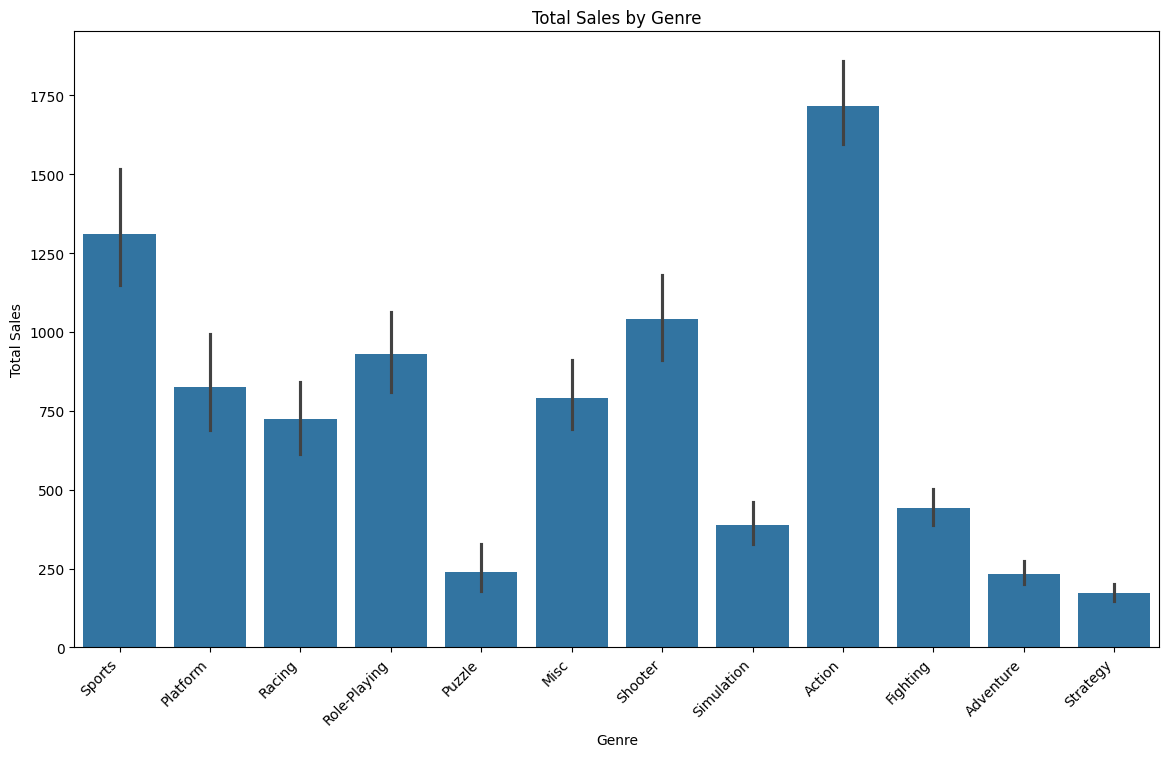

In [25]:
plt.figure(figsize=(14, 8))
sns.barplot(x='genre', y='total_sales', data=games, estimator=sum)
plt.title('Total Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

Action and sports games are the highest sellers while puzzle and strategy games have the lowest sales. It seems like people tend to like action games over thinking games.

NA_sales, EU_sales, JP_sales, Other_sales

Top five platforms in NA_SALES:
platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

Top five platforms in EU_SALES:
platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64

Top five platforms in JP_SALES:
platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64

Top five platforms in OTHER_SALES:
platform
PS4     48.35
PS3     43.26
X360    20.40
XOne    14.27
3DS      8.87
Name: other_sales, dtype: float64



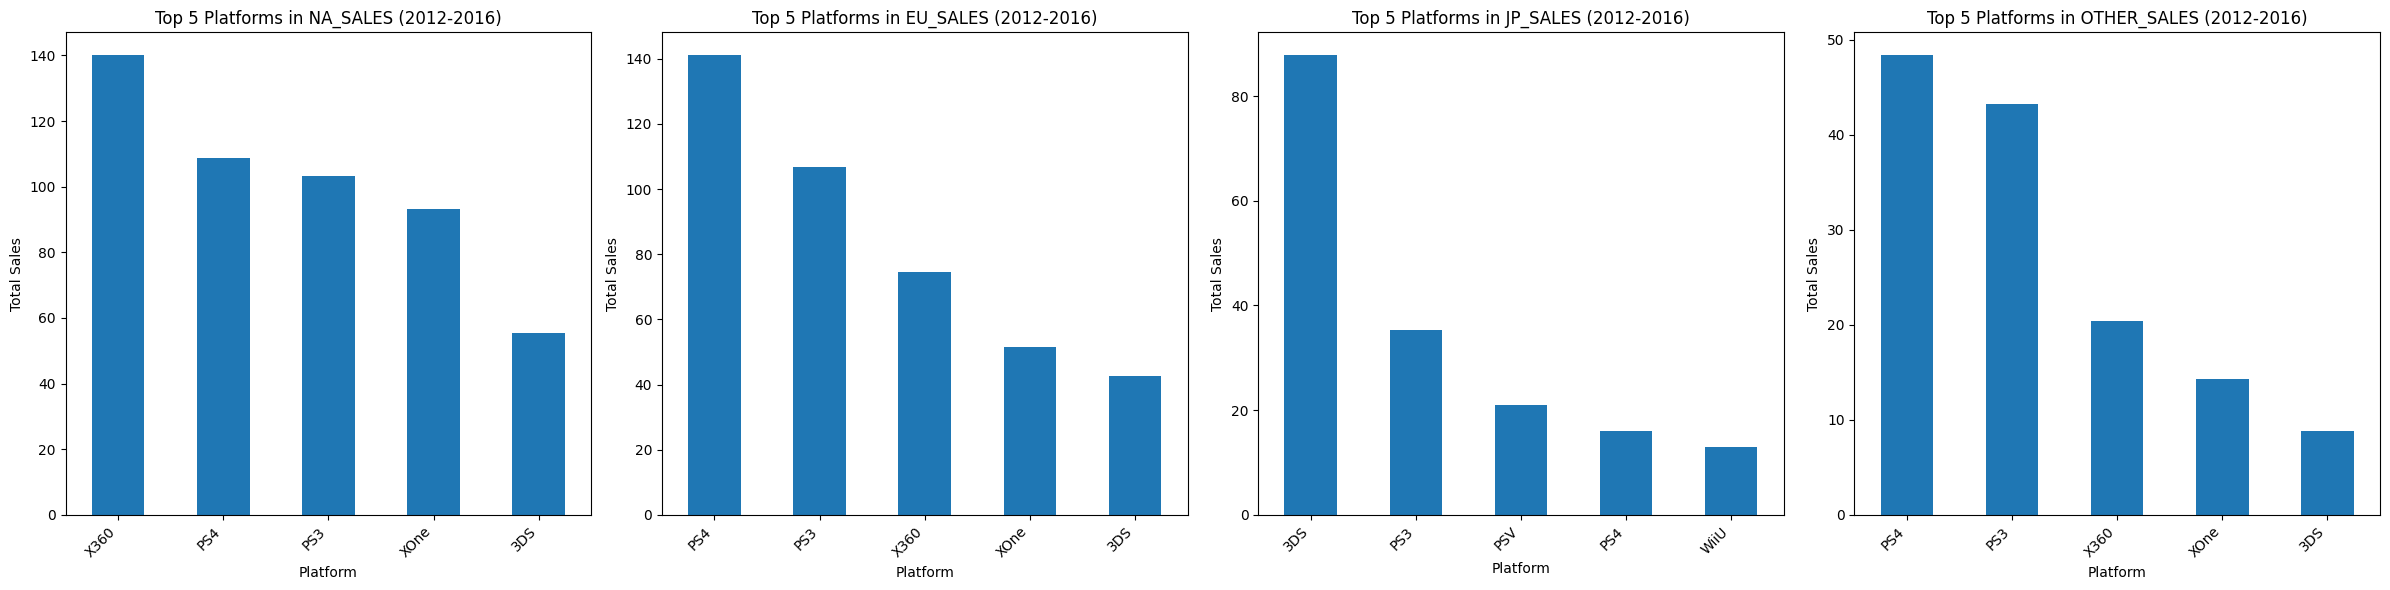

In [26]:
# Filter the data for the years 2012 to 2016
filtered_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Define regions
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Create a dictionary to store the top five platforms for each region
top_platforms_per_region = {}

# Calculate the top five platforms for each region
for region in regions:
    region_sales = filtered_games.groupby('platform')[region].sum().sort_values(ascending=False)
    top_platforms_per_region[region] = region_sales.head(5)

# Display the top five platforms for each region
for region, platforms in top_platforms_per_region.items():
    print(f"Top five platforms in {region.upper()}:")
    print(platforms)
    print()

# Plot the market share variations for each region
plt.figure(figsize=(24, 6))

for i, region in enumerate(regions, 1):
    plt.subplot(1, 4, i)
    top_platforms_per_region[region].plot(kind='bar')
    plt.title(f'Top 5 Platforms in {region.upper()} (2012-2016)')
    plt.xlabel('Platform')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

While the PS4 is popular in NA, EU and Other the X360 is the most popular in NA. However, the PS4 is the most popular in the EU and Other. JP seems to be a little different with the 3DS being the most popular and the PS3 being the second choice with the PS4 only being the 4th most popular.

Top five genres in NA_SALES:
genre
Action          177.84
Shooter         144.77
Role-Playing     64.00
Sports           81.53
Misc             38.19
Name: na_sales, dtype: float64

Top five genres in EU_SALES:
genre
Action          159.34
Shooter         113.47
Role-Playing     48.53
Sports           69.09
Misc             26.32
Name: eu_sales, dtype: float64

Top five genres in JP_SALES:
genre
Action          52.80
Shooter          9.23
Role-Playing    65.44
Sports           8.01
Misc            12.86
Name: jp_sales, dtype: float64

Top five genres in OTHER_SALES:
genre
Action          51.14
Shooter         37.26
Role-Playing    14.83
Sports          22.44
Misc             7.67
Name: other_sales, dtype: float64



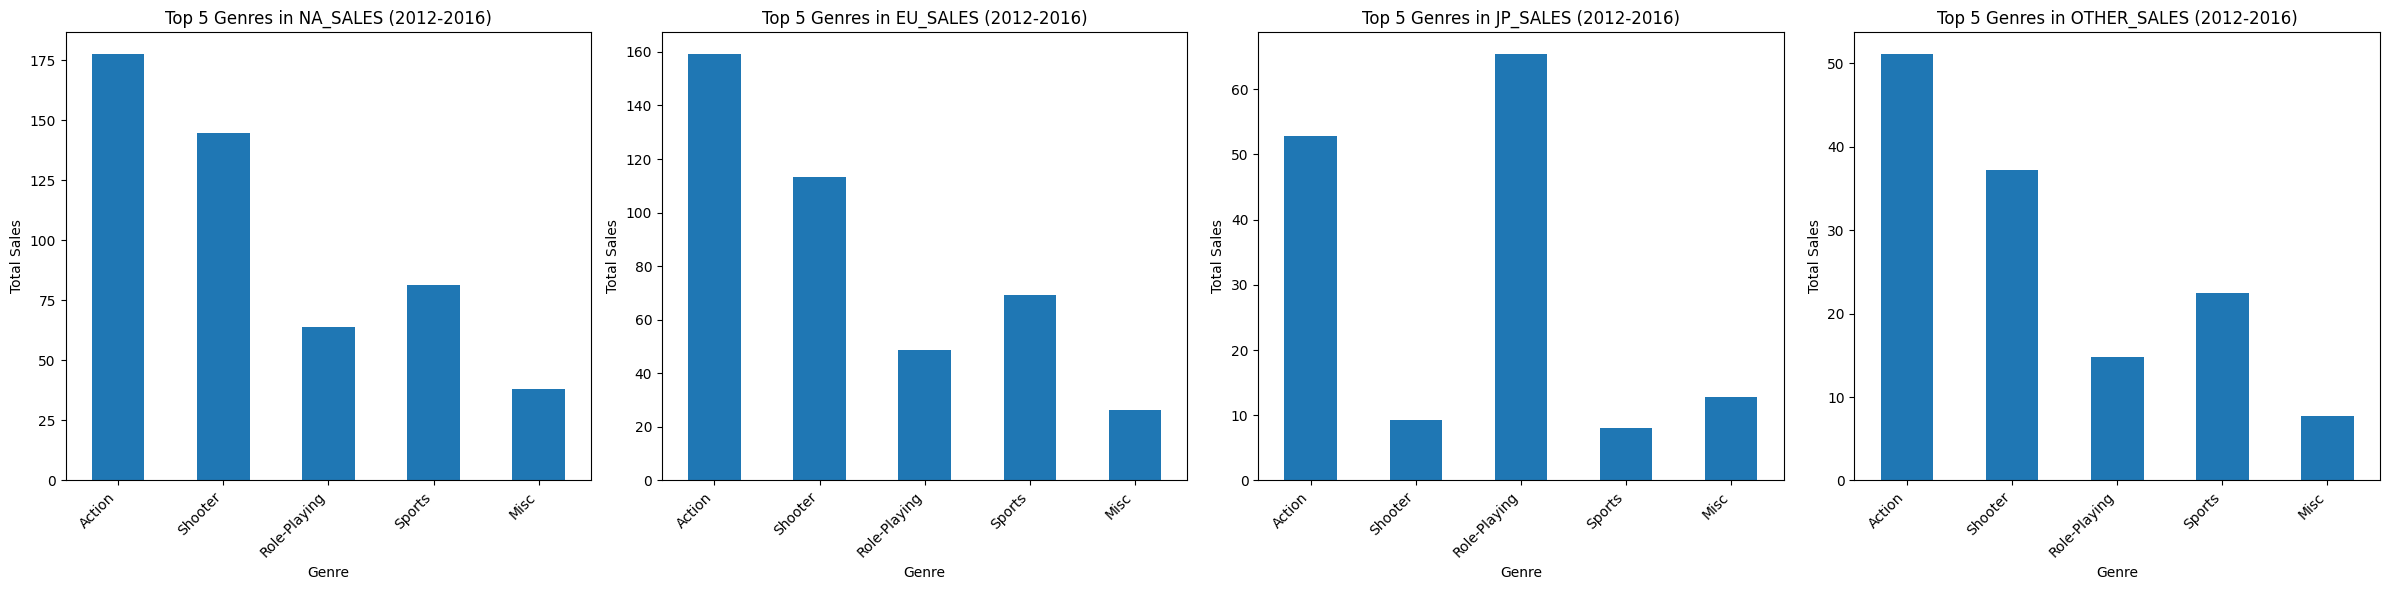

In [27]:
# Filter the data for the years 2012 to 2016
filtered_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Calculate total sales per genre
genre_sales = filtered_games.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Choose top five genres
top_genres = genre_sales.head(5).index

# Define regions
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Create a dictionary to store the sales for each genre in each region
genre_sales_per_region = {region: filtered_games.groupby('genre')[region].sum() for region in regions}

# Filter the dictionary to include only the top five genres
top_genre_sales_per_region = {region: sales[top_genres] for region, sales in genre_sales_per_region.items()}

# Display the top five genres and their sales in each region
for region, sales in top_genre_sales_per_region.items():
    print(f"Top five genres in {region.upper()}:")
    print(sales)
    print()

# Plot the market share variations for each genre in each region
plt.figure(figsize=(24, 6))

for i, region in enumerate(regions, 1):
    plt.subplot(1, 4, i)
    top_genre_sales_per_region[region].plot(kind='bar')
    plt.title(f'Top 5 Genres in {region.upper()} (2012-2016)')
    plt.xlabel('Genre')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

The most popular genre of games in NA, EU and other are Action followed by Shooters. They take the main market share. JP differs in that the most popular genre is Role playing, followed by action games. While action games are popular in JP they are not as popular as in NA or EU.

Looking at Rating (ESRB) correlation

In [28]:
# Filter the data for the years 2012 to 2016
filtered_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Define regions
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Initialize a dictionary to store the correlation results
rating_sales_corr = {}

# Calculate the correlation between rating and sales for each region
for region in regions:
    # Drop rows with missing values in 'rating' or the region sales column
    filtered_data = filtered_games.dropna(subset=['rating', region]).copy()
    
    # Convert rating to a numerical value
    filtered_data.loc[:, 'rating_num'] = filtered_data['rating'].astype('category').cat.codes
    
    # Calculate the correlation
    corr = filtered_data['rating_num'].corr(filtered_data[region])
    rating_sales_corr[region] = corr

# Display the correlation results
for region, corr in rating_sales_corr.items():
    print(f"Correlation between Rating and {region.upper()} Sales (2012-2016): {corr}")

Correlation between Rating and NA_SALES Sales (2012-2016): -0.026798218496943683
Correlation between Rating and EU_SALES Sales (2012-2016): -0.04834484609369452
Correlation between Rating and JP_SALES Sales (2012-2016): -0.009653813947611212
Correlation between Rating and OTHER_SALES Sales (2012-2016): -0.018183198689939


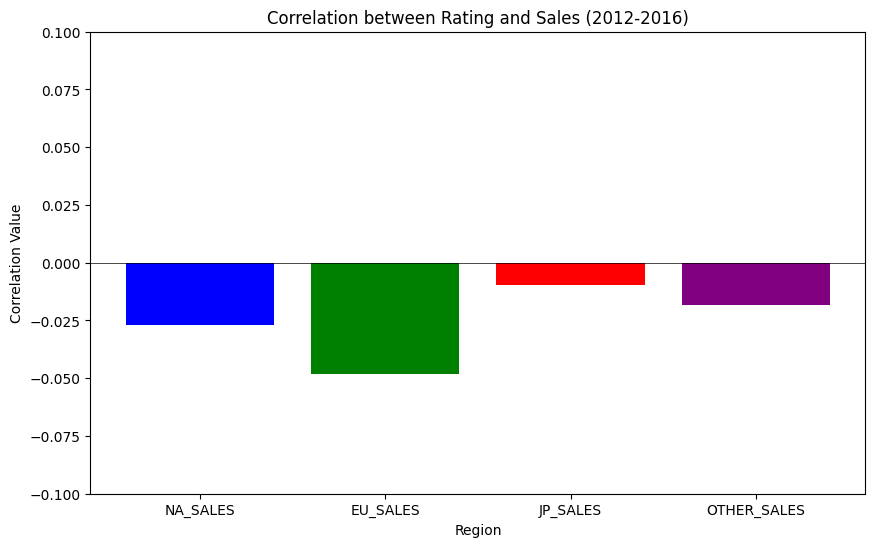

In [29]:
# Define the correlation values
correlation_values = {
    'NA_SALES': -0.026798218496943683,
    'EU_SALES': -0.04834484609369452,
    'JP_SALES': -0.009653813947611212,
    'OTHER_SALES': -0.018183198689939
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(correlation_values.keys(), correlation_values.values(), color=['blue', 'green', 'red', 'purple'])
plt.title('Correlation between Rating and Sales (2012-2016)')
plt.xlabel('Region')
plt.ylabel('Correlation Value')
plt.ylim(-0.1, 0.1)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

The data appears to show little no correlation to ESRB rating having an effect on game sales.

In [30]:
# Filter the data for Xbox One and PC platforms from 2012 to 2016
xbox_one_ratings = games[(games['platform'] == 'XOne') & (games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]['user_score'].dropna()
pc_ratings = games[(games['platform'] == 'PC') & (games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]['user_score'].dropna()

# Perform the t-test
t_stat, p_value = ttest_ind(xbox_one_ratings, pc_ratings)

# Set the alpha threshold value
alpha = 0.05

# Display the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Determine if we reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis: The average user ratings of the Xbox One and PC platforms are different.")
else:
    print("Fail to reject the null hypothesis: The average user ratings of the Xbox One and PC platforms are the same.")

T-statistic: 1.039494293540339
P-value: 0.29908238234386986
Fail to reject the null hypothesis: The average user ratings of the Xbox One and PC platforms are the same.


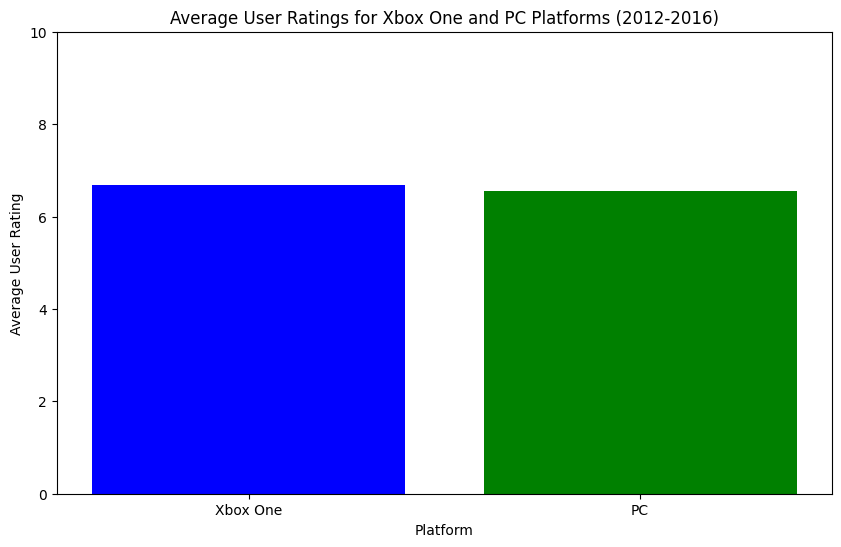

In [31]:
# Calculate the average user ratings for Xbox One and PC platforms
avg_xbox_one_rating = xbox_one_ratings.mean()
avg_pc_rating = pc_ratings.mean()

# Create a bar graph
plt.figure(figsize=(10, 6))
platforms = ['Xbox One', 'PC']
avg_ratings = [avg_xbox_one_rating, avg_pc_rating]
plt.bar(platforms, avg_ratings, color=['blue', 'green'])
plt.title('Average User Ratings for Xbox One and PC Platforms (2012-2016)')
plt.xlabel('Platform')
plt.ylabel('Average User Rating')
plt.ylim(0, 10)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

The null hypothesis was asked in the assignment. Test to see if the user ratings from Xbox and PC are the same. So, conversely the alternative hypothesis would be that the users’ ratings are different. The significance level (alpha 0.05) was chosen because it is an industry standard, and I did not have a good justification for changing it. The ratings from both platforms were the same. This could be due to some overlap for the users having both platforms. Also, people could have similar opinions no matter what platform they are on.

In [32]:
# Filter the data for the years 2012 to 2016
filtered_games = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Filter the data for Action and Sports genres
action_ratings = filtered_games[filtered_games['genre'] == 'Action']['user_score'].dropna()
sports_ratings = filtered_games[filtered_games['genre'] == 'Sports']['user_score'].dropna()

# Perform the t-test
t_stat, p_value = ttest_ind(action_ratings, sports_ratings)

# Set the alpha threshold value
alpha = 0.05

# Display the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Determine if we reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis: The average user ratings for the Action and Sports genres are different.")
else:
    print("Fail to reject the null hypothesis: The average user ratings for the Action and Sports genres are the same.")

T-statistic: 13.362129428332727
P-value: 3.000610263906363e-38
Reject the null hypothesis: The average user ratings for the Action and Sports genres are different.


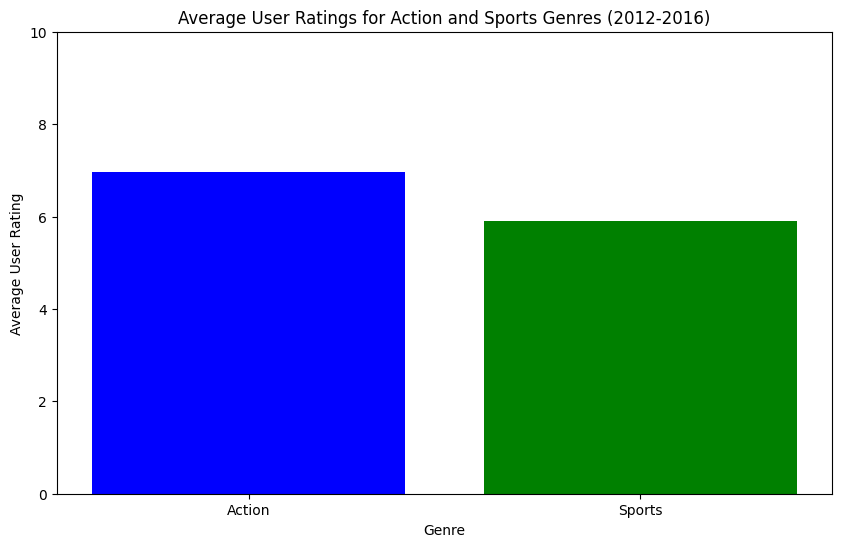

In [33]:
# Calculate the average user ratings for Action and Sports genres
avg_action_rating = action_ratings.mean()
avg_sports_rating = sports_ratings.mean()

# Create a bar graph
plt.figure(figsize=(10, 6))
genres = ['Action', 'Sports']
avg_ratings = [avg_action_rating, avg_sports_rating]
plt.bar(genres, avg_ratings, color=['blue', 'green'])
plt.title('Average User Ratings for Action and Sports Genres (2012-2016)')
plt.xlabel('Genre')
plt.ylabel('Average User Rating')
plt.ylim(0, 10)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

The null hypothesis was asked in the assignment. Test to see if the average user ratings for the Action and Sports genres are the same. So, conversely the alternative hypothesis would be that the users’ ratings are different. The significance level (alpha 0.05) was chosen because it is an industry standard, and I did not have a good justification for changing it. There is a slight difference in ratings from action games to sports games with action games being rated higher.

Conclusion:

When forecasting for target markets the following platforms should be considered the best to target. PS4, X360, and 3DS in the NA, EU and JP regions. The reasoning is that they are the top selling platforms and the most recent platform released by each manufacturer. They will continue to grow and therefore people will be looking to use them the most.  While PS3 still has a high market share, it is not the most recent platform from that manufacturer and sales will fade. Considering game genres to target we should look at Action and Shooter games in NA, Eu and Other markets and Role Playing and Action games for JP markets. These games consistently have the highest sales in their respective markets. The data is pulled from 2012 to 2016 because it gives the most relevant and consistent data in recent years. The early years of gaming data are not a good marker because gaming was not as popular.  2001 to 2011 showed a large increase in gaming but it could not be sustained so that data would not be a good predictor moving forward. Another consideration is that since marketing campaigns have limited budgets, we do not target “Other” sales areas since they have the lowest market share and it would be divided between many different countries.

